In [1]:
import matplotlib
import requests
import json
import pylab
import io
import numpy as np
from astropy.io import ascii
from astropy.table import Table
from astropy.io.votable import parse,parse_single_table,from_table, writeto
from astropy.coordinates import SkyCoord
from astropy import units as u

In [ ]:
'''
rutas
http://3.212.59.238:8787/radio-degree
http://3.212.59.238:8787/radio-degree-nearest # entrega un solo objeto en caso de encontrar
http://3.212.59.238:8787/radio-hms
http://3.212.59.238:8787/radio-hms-nearest # entrega un solo objeto en caso de encontrar
'''

In [11]:
def consulta_degree(ra,dec,radius,format,catalog):
    url = 'http://127.0.0.1:5000/radio-degree'
    params = {'ra':ra,'dec':dec,'radius':radius,'format':format,'catalog':catalog}
    r = requests.post(url, data=params)
    return r

In [12]:
def consulta_hms(hms,radius,format,catalog):
    url = 'http://127.0.0.1:5000/radio-hms'
    params = {'hms':hms,'radius':radius,'format':format,'catalog':catalog}
    r = requests.post(url, data=params)
    return r

In [18]:
#consulta por grados
# consulta_degree(139.33444972,68.6350604,0.0002777,'csv','ztf,ps1') 
rdg = consulta_degree(139.33444972,68.6350604,0.0002777,'votable','ztf')

In [19]:
# clave de catalogos consultados
catalog = rdg.json().keys()
catalog

dict_keys(['curve_ztf'])

In [20]:
#claves de los elementos en X catalogo
rdg.json()['curve_ztf'].keys()

dict_keys(['1848215200006181', '841108100002803', '841208100004637'])

In [21]:
#consulta hours
#hms_tuple(h=9.0, m=17.0, s=20.26793280000689)
#hms_tuple(h=4.0, m=34.0, s=32.414496000003936)
#'9h17m20.26793280000689s + 4h34m32.414496000003936s'

rhms = consulta_hms('9h17m20.26793280000689s + 4h34m32.414496000003936s',0.0002777,'csv','ztf' )
#rhrs.text

In [17]:
rhms.json()['curve_ztf'].keys()

dict_keys(['1848215200006181', '841108100002803', '841208100004637'])

In [36]:
# devuelve la tabla de astropy (para procesesar)en caso de recibir un VOTable
votable = rdg.json()['curve_ztf']['841208100004637'].encode(encoding='UTF-8')
bio = io.BytesIO(votable)
table = parse_single_table(bio).to_table()

#en caso de quererlo como votable
#votable = parse(bio)
#votable.get_frist_table()

In [50]:
# devuelve la tabla de astropy, en caso de recivir un csv
tabla = ascii.read(rdg.json()['curve_ps1']['190361393344112894'],  format='csv', guess=False)
tabla

objID,detectID,filterID,obsTime,ra,dec,psfFlux,psfFluxErr,psfMajorFWHM,psfMinorFWHM,psfQfPerfect,apFlux,apFluxErr,infoFlag,infoFlag2,infoFlag3
int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64
190361393344112894,153443866410000015,3,55635.4389349,139.33447819,68.63506142,0.008843869902193546,1.0087999726238195e-05,1.548509955406189,1.4958100318908691,0.9047060012817383,0.008679470047354698,1.0326800293114502e-05,102760517,128,7374912
190361393344112894,153445192410000017,3,55635.4521903,139.33449752,68.63506221,0.008280499838292599,1.0222100172541104e-05,1.9910399913787842,1.956779956817627,0.9989989995956421,0.00838323961943388,1.0059299711429048e-05,102760517,128,7374912
190361393344112894,153347716310000010,1,55634.477414,139.3345207,68.63503577,0.00826191995292902,1.1407400052121375e-05,1.881850004196167,1.7673399448394775,0.9929159879684448,0.008617050014436245,1.1423299838497769e-05,102760517,128,124782656
190361393344112894,153348968310000008,1,55634.4899457,139.33448821,68.63506146,0.007737299893051386,1.102680016629165e-05,1.8103100061416626,1.605180025100708,0.9984610080718994,0.007921719923615456,1.0940600077447016e-05,102760517,128,124782656
190361393344112894,153441340410000012,2,55635.4136426,139.33447173,68.6350534,0.009787579998373985,1.1084300240327138e-05,1.6787899732589722,1.5652999877929688,0.9985089898109436,0.009907630272209644,1.1123100193799473e-05,102760517,128,124815424
190361393344112894,153442549410000013,2,55635.4257356,139.33447732,68.63505279,0.009362099692225456,1.1004999578290153e-05,1.3472399711608887,1.2095199823379517,0.40749600529670715,0.009506789967417717,1.0994899639626965e-05,102760517,160,34880
190361393344112894,118025265260000028,4,55281.2528285,139.33447243,68.63507592,0.005556920077651739,1.2427400179149117e-05,1.1078200340270996,0.9493029713630676,0.9975399971008301,0.005616980139166117,1.2113199773011729e-05,102760517,128,7374912
190361393344112894,118026233260000017,4,55281.2625151,139.3344753,68.63507505,0.006145799998193979,1.3183999726606999e-05,1.0866999626159668,0.9652569890022278,0.9555839896202087,0.006260519847273827,1.2802999663108494e-05,102760517,128,7374912
190361393344112894,115636667260000047,5,55257.3668569,139.33445713,68.63507615,0.005354930181056261,2.6245999833918177e-05,2.5283899307250977,2.4677300453186035,0.9989349842071533,0.005433760117739439,1.6695599697413854e-05,102760517,128,24119360


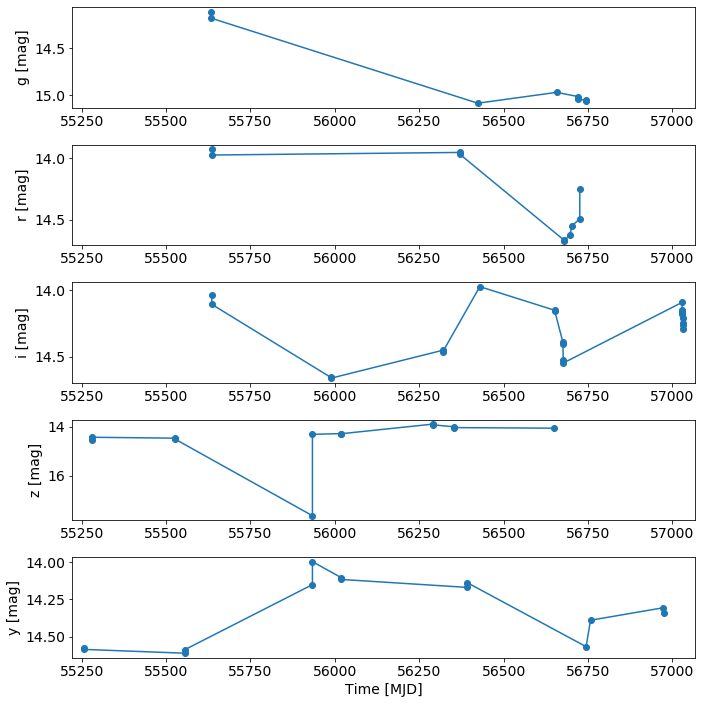

In [57]:
## para graficar, siendo una tabla de PS1
if 'curve_ps1' in catalog:
    dtab_pan = tabla # la tabla en astropy, de un elemento
    id2filter = np.array(list('grizy'))
    dtab_pan['filter'] = id2filter[(dtab_pan['filterID']-1).data]
    dtab_pan.sort('obsTime')
    
    # convert flux in Jy to magnitudes
    t = dtab_pan['obsTime']
    mag = -2.5*np.log10(dtab_pan['psfFlux']) + 8.90
    xlim = np.array([t.min(),t.max()])
    xlim = xlim + np.array([-1,1])*0.02*(xlim[1]-xlim[0])

    pylab.rcParams.update({'font.size': 14})
    pylab.figure(1,(10,10))
    for i, filter in enumerate("grizy"):
        pylab.subplot(511+i)
        w = np.where(dtab_pan['filter']==filter)
        pylab.plot(t[w],mag[w],'-o')
        pylab.ylabel(filter+' [mag]')
        pylab.xlim(xlim)
        pylab.gca().invert_yaxis()
    # if i==0:
       # pylab.title(objname)
    pylab.xlabel('Time [MJD]')
    pylab.tight_layout()
    #print(dtab)

In [64]:
tabla = ascii.read(rdg.json()['curve_ztf']['841108100002803'],  format='csv', guess=False)
print(tabla.columns)
tabla['filtercode','field','limitmag','magzp']

<TableColumns names=('oid','expid','hjd','mjd','mag','magerr','catflags','filtercode','ra','dec','chi','sharp','filefracday','field','ccdid','qid','limitmag','magzp','magzprms','clrcoeff','clrcounc','exptime','airmass','programid')>


filtercode,field,limitmag,magzp
str2,int64,float64,float64
zg,841,19.9699993,26.2987614
zg,841,20.0,26.3244419
zg,841,20.0699997,26.1978493
zg,841,19.8500004,25.9768658
zg,841,20.3799992,26.1693344
zg,841,20.4799995,26.1755791
zg,841,21.2700005,26.2607956
zg,841,20.2999992,26.2822933
zg,841,20.2199993,26.0177231


In [78]:
'mag{}'.format(tabla['filtercode'][0])

'magzg'

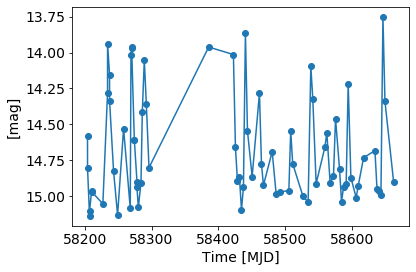

In [95]:
# Para graficar desde una tabla proveniente de ZTF
#
# En construccion
#
if 'curve_ztf' in catalog:
    dtab_ztf = tabla # la respectiva tabla de ztf
    dtab_ztf.sort('mjd')
    
    t = dtab_ztf['mjd']
    #magtag = 'mag{}'.format(tabla['filtercode'][0])
    #mag = dtab_ztf[magtag]
    pylab.rcParams.update({'font.size': 14})
    #pylab.figure(1,(10,10))
    
    pylab.plot(dtab_ztf['mjd'],dtab_ztf['mag'],'-o')
    pylab.ylabel('[mag]')
    #pylab.xlim(xlim)
    pylab.gca().invert_yaxis()
    
    pylab.xlabel('Time [MJD]')
    pylab.tight_layout()
    

In [65]:
np.array(list('grizy'))

array(['g', 'r', 'i', 'z', 'y'], dtype='<U1')